In [449]:
import pandas as pd

In [450]:
Data =pd.read_csv('suorena.csv')
Data

,#,BookingDate,generalStatus
0,1,2024-02-12 11:29:00.030000,0
1,2,2024-02-14 08:58:27.378000,0
2,3,2024-02-14 10:57:43.979000,0
3,4,2024-02-14 11:01:23.808000,0
4,5,2024-02-14 11:01:53.198000,0
...,...,...,...
6573,6574,2024-07-17 12:53:37.751000,3
6574,6575,2024-07-17 13:04:03.361000,3
6575,6576,2024-07-17 13:59:37.115000,3
6576,6577,2024-07-17 13:59:58.613000,3


In [451]:
type(Data['BookingDate'].iloc[0])

str

In [452]:
Data['BookingDate'] = pd.to_datetime(Data['BookingDate'])

In [453]:
unsuccessfullbuy = Data[Data['generalStatus']==0]
successfullbuy = Data[Data['generalStatus']==3]

In [454]:
successfullbuy

,#,BookingDate,generalStatus
64,65,2024-02-21 16:03:05.037,3
68,69,2024-02-21 12:49:37.192,3
69,70,2024-02-21 11:44:02.896,3
73,74,2024-02-26 09:38:05.826,3
78,79,2024-02-26 11:42:09.870,3
...,...,...,...
6573,6574,2024-07-17 12:53:37.751,3
6574,6575,2024-07-17 13:04:03.361,3
6575,6576,2024-07-17 13:59:37.115,3
6576,6577,2024-07-17 13:59:58.613,3


In [455]:
# Set the datetime column as the index
unsuccessfullbuy.set_index('BookingDate', inplace=True)
successfullbuy.set_index('BookingDate', inplace=True)

In [456]:

# Count events in every 4-hour window
unsuccessfullbuy_counts = unsuccessfullbuy.resample('24H').count()

unsuccessfullbuy_counts.rename(columns={'#':'value'}, inplace=True)
unsuccessfullbuy_counts=unsuccessfullbuy_counts.drop('generalStatus', axis=1) 
unsuccessfullbuy_counts

,value
BookingDate,
2024-02-12,1
2024-02-13,0
2024-02-14,17
2024-02-15,2
2024-02-16,1
...,...
2024-07-13,7
2024-07-14,11
2024-07-15,0


In [457]:
# Count events in every 4-hour window
successfullbuy_counts = successfullbuy.resample('24H').count()

successfullbuy_counts.rename(columns={'#':'value'}, inplace=True)
successfullbuy_counts=successfullbuy_counts.drop('generalStatus', axis=1)
successfullbuy_counts

,value
BookingDate,
2024-02-19,1
2024-02-20,0
2024-02-21,4
2024-02-22,0
2024-02-23,0
...,...
2024-07-13,30
2024-07-14,29
2024-07-15,14


In [458]:
unsuccessfullbuy_counts.describe()

,value
count,157.000000
mean,8.299363
std,8.410513
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,50.000000


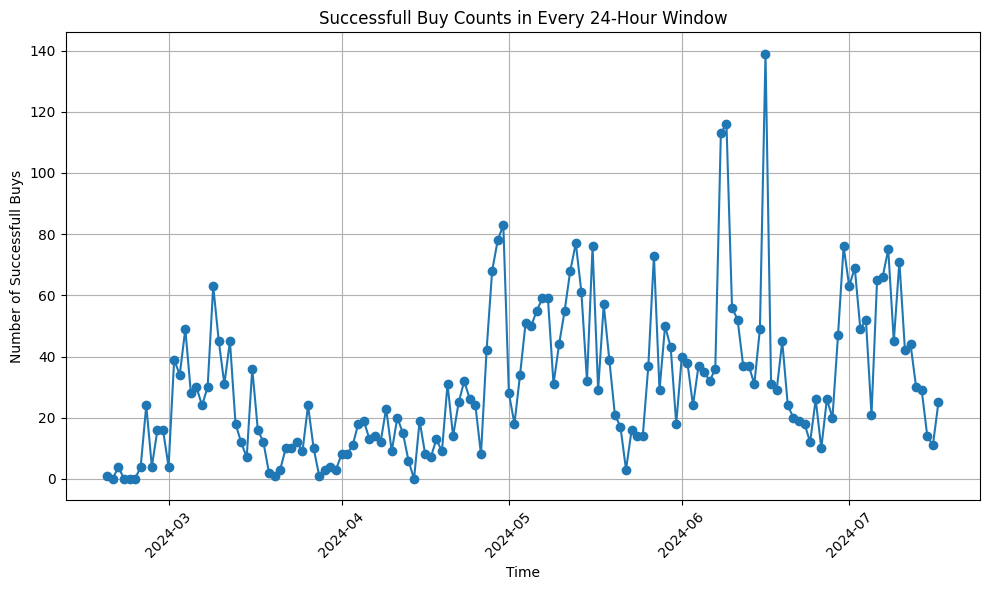

In [459]:
import matplotlib.pyplot as plt
# Plot the event counts
plt.figure(figsize=(10, 6))
plt.plot(successfullbuy_counts.index, successfullbuy_counts['value'], marker='o')
plt.title('Successfull Buy Counts in Every 24-Hour Window')
plt.xlabel('Time')
plt.ylabel('Number of Successfull Buys')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('1.png')
plt.show()


In [460]:
# Create columns for the past n values
n=3
for i in range(1, n+1):
    unsuccessfullbuy_counts[f'past_{i}'] = unsuccessfullbuy_counts['value'].shift(i)

# Drop rows with NaN values (the first 9 rows won't have complete past 10 values)
unsuccessfullbuy_counts.dropna(inplace=True)

In [461]:
unsuccessfullbuy_counts

,value,past_1,past_2,past_3
BookingDate,,,,
2024-02-15,2,17.0,0.0,1.0
2024-02-16,1,2.0,17.0,0.0
2024-02-17,0,1.0,2.0,17.0
2024-02-18,3,0.0,1.0,2.0
2024-02-19,2,3.0,0.0,1.0
...,...,...,...,...
2024-07-13,7,11.0,8.0,6.0
2024-07-14,11,7.0,11.0,8.0
2024-07-15,0,11.0,7.0,11.0


In [462]:
X = unsuccessfullbuy_counts.values

In [463]:
from sklearn.ensemble import IsolationForest
clfIF = IsolationForest(n_estimators=200, contamination='auto',random_state=12)


In [464]:
unsuccessfullbuy_counts['IF'] = clfIF.fit_predict(X)

In [465]:
import pickle 
# save
with open('if_model_unsuccessfullPayment.pkl','wb') as f:
    pickle.dump(clfIF,f)

In [466]:
# load
with open('if_model_unsuccessfullPayment.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [467]:
clf2.predict(X[0,:].reshape(1,-1))

array([1])

In [468]:
X[0,:].reshape(1, -1)

array([[ 2., 17.,  0.,  1.]])

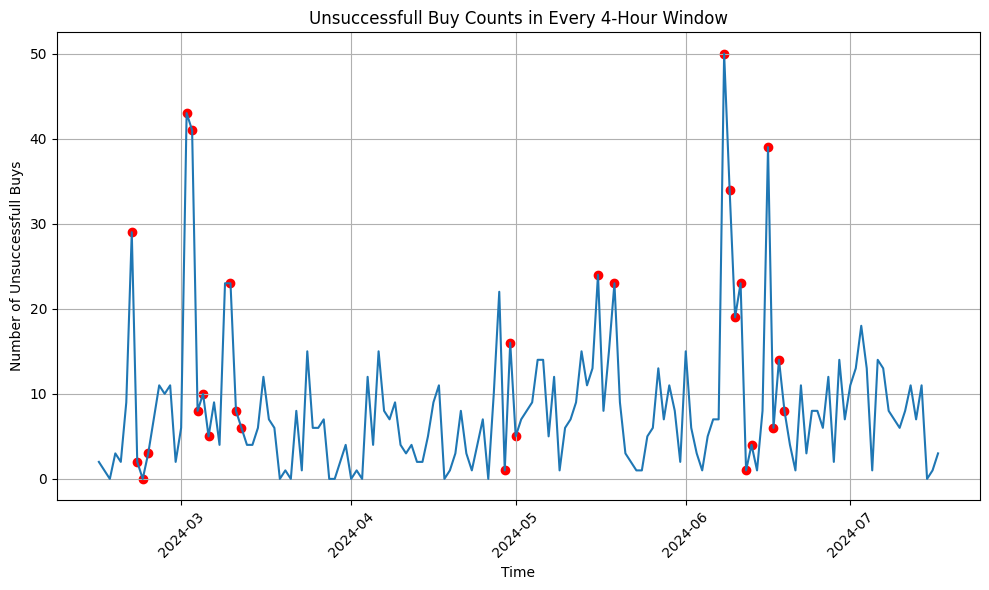

In [469]:
import matplotlib.pyplot as plt
# Plot the event counts
plt.figure(figsize=(10, 6))
plt.plot(unsuccessfullbuy_counts.index, unsuccessfullbuy_counts['value'])
plt.scatter(unsuccessfullbuy_counts[unsuccessfullbuy_counts['IF']==-1].index, unsuccessfullbuy_counts[unsuccessfullbuy_counts['IF']==-1]['value'], marker='o',color='red')
plt.title('Unsuccessfull Buy Counts in Every 4-Hour Window')
plt.xlabel('Time')
plt.ylabel('Number of Unsuccessfull Buys')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [470]:
unsuccessfullbuy_counts[unsuccessfullbuy_counts['IF']==-1].index

DatetimeIndex(['2024-02-21', '2024-02-22', '2024-02-23', '2024-02-24',
               '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
               '2024-03-06', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-16',
               '2024-05-19', '2024-06-08', '2024-06-09', '2024-06-10',
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-16',
               '2024-06-17', '2024-06-18', '2024-06-19'],
              dtype='datetime64[ns]', name='BookingDate', freq=None)

In [471]:
n=3
for i in range(1, n+1):
    successfullbuy_counts[f'past_{i}'] = successfullbuy_counts['value'].shift(i)

# Drop rows with NaN values (the first 9 rows won't have complete past 10 values)
successfullbuy_counts.dropna(inplace=True)

In [472]:
successfullbuy_counts

,value,past_1,past_2,past_3
BookingDate,,,,
2024-02-22,0,4.0,0.0,1.0
2024-02-23,0,0.0,4.0,0.0
2024-02-24,0,0.0,0.0,4.0
2024-02-25,4,0.0,0.0,0.0
2024-02-26,24,4.0,0.0,0.0
...,...,...,...,...
2024-07-13,30,44.0,42.0,71.0
2024-07-14,29,30.0,44.0,42.0
2024-07-15,14,29.0,30.0,44.0


In [473]:
X = successfullbuy_counts.values

In [474]:
from sklearn.ensemble import IsolationForest
clfIF_s = IsolationForest(n_estimators=200, contamination='auto',random_state=12)
successfullbuy_counts['IF'] = clfIF_s.fit_predict(X)

In [475]:
import pickle 
# save
with open('if_model_successfullPayment.pkl','wb') as f:
    pickle.dump(clfIF_s,f)

In [476]:
# load
with open('if_model_unsuccessfullPayment.pkl', 'rb') as f:
    clf3 = pickle.load(f)

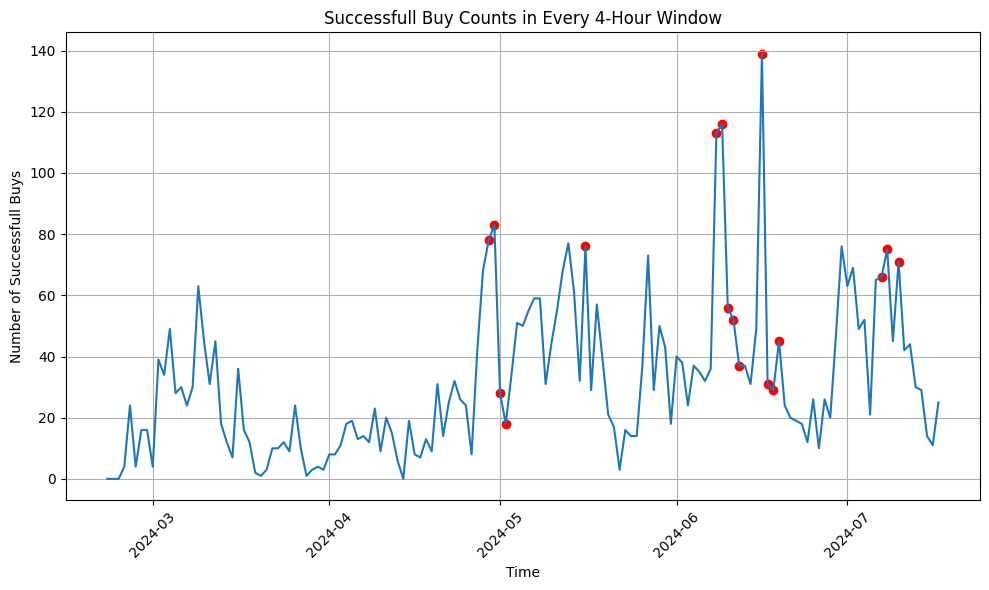

In [477]:
import matplotlib.pyplot as plt
# Plot the event counts
plt.figure(figsize=(10, 6))
plt.plot(successfullbuy_counts.index, successfullbuy_counts['value'])
plt.scatter(successfullbuy_counts[successfullbuy_counts['IF']==-1].index, successfullbuy_counts[successfullbuy_counts['IF']==-1]['value'], marker='o',color='red')
plt.title('Successfull Buy Counts in Every 4-Hour Window')
plt.xlabel('Time')
plt.ylabel('Number of Successfull Buys')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

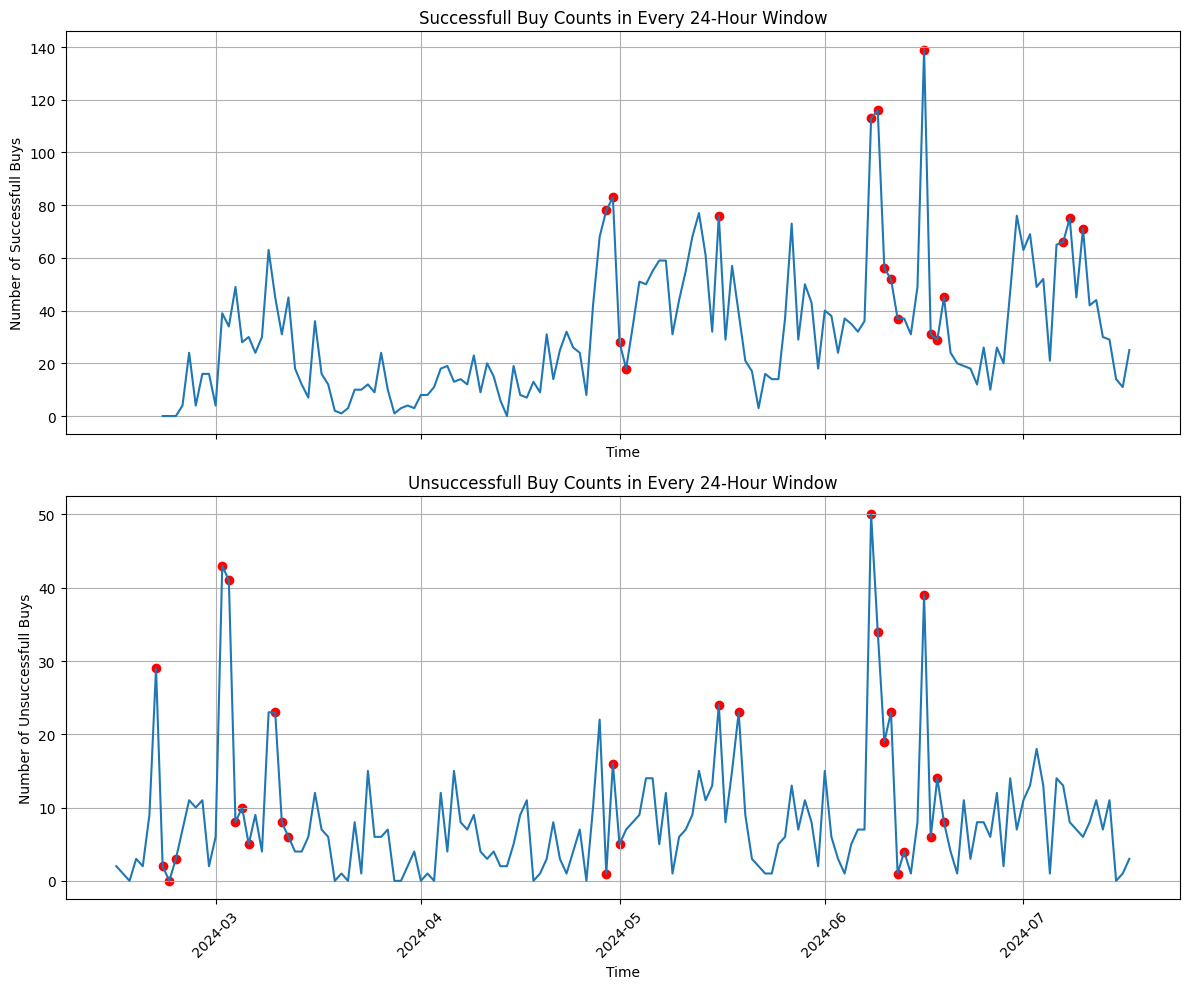

In [478]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax[0].plot(successfullbuy_counts.index, successfullbuy_counts['value'])
ax[0].scatter(successfullbuy_counts[successfullbuy_counts['IF']==-1].index, successfullbuy_counts[successfullbuy_counts['IF']==-1]['value'], marker='o',color='red')
ax[0].set_title('Successfull Buy Counts in Every 24-Hour Window')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of Successfull Buys')
ax[0].grid(True)


ax[1].plot(unsuccessfullbuy_counts.index, unsuccessfullbuy_counts['value'])
ax[1].scatter(unsuccessfullbuy_counts[unsuccessfullbuy_counts['IF']==-1].index, unsuccessfullbuy_counts[unsuccessfullbuy_counts['IF']==-1]['value'], marker='o',color='red')
ax[1].set_title('Unsuccessfull Buy Counts in Every 24-Hour Window')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Number of Unsuccessfull Buys')
ax[1].grid(True)


# Adjust x-ticks rotation
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('1.png')
plt.show()

In [295]:
import psycopg2

# Define connection parameters
conn_params = {
    "dbname": "daric",
    "user": "aiexpert",
    "password": "q74vj3.cV#1V",
    "host": "78.157.39.122",  # e.g., "localhost" or an IP address
    "port": "5432"  # e.g., 5432
}

try:
    # Establish a connection to the database
    connection = psycopg2.connect(**conn_params)
    cursor = connection.cursor()

    # Print PostgreSQL Connection properties
    print(connection.get_dsn_parameters(), "\n")

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch the result
    db_version = cursor.fetchone()
    print("You are connected to - ", db_version, "\n")

    # Example of a SELECT query
    cursor.execute("SELECT * FROM booking;")
    rows = cursor.fetchall()
    #for row in rows:
        #print(row)

    # Example of an INSERT query
    cursor.execute("INSERT INTO booking (generalStatus, BookingDate) VALUES (%s, %s)", ('value1', 'value2'))
    connection.commit()

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    # Closing database connection
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")


{'user': 'aiexpert', 'channel_binding': 'prefer', 'dbname': 'daric', 'host': '78.157.39.122', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

You are connected to -  ('PostgreSQL 16.2 (Ubuntu 16.2-1.pgdg22.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0, 64-bit',) 

Error while connecting to PostgreSQL column "generalstatus" of relation "booking" does not exist
LINE 1: INSERT INTO booking (generalStatus, BookingDate) VALUES ('va...
                             ^

PostgreSQL connection is closed


In [297]:
rows[0]

('effef3e0-2ccf-4680-979e-715e5f4dd3de',
 'TKPWE',
 None,
 'c75b16a6-df1f-4b5a-9a3e-f69eb84da013',
 0,
 None,
 datetime.datetime(2024, 2, 12, 11, 29, 0, 30000),
 '65c9cee083698d870535776c',
 '578f52c9-69a6-4af8-bed3-45cf4171d03f',
 'ea5f5ece-c8c9-4f47-a734-743864337243',
 1,
 None,
 '112000',
 '112000',
 'AD',
 '500',
 None,
 datetime.datetime(2024, 2, 12, 11, 29, 0, 30000),
 datetime.datetime(2024, 2, 12, 11, 29, 0, 30000),
 None)

In [299]:
connection = psycopg2.connect(**conn_params)
cursor = connection.cursor()
cursor.execute("SELECT * FROM booking;")
rows = cursor.fetchall()

In [294]:
for row in rows:
    print(row)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [309]:
try:
    # Establish a connection to the database
    connection = psycopg2.connect(**conn_params)
    cursor = connection.cursor()

    # Print PostgreSQL Connection properties
    print(connection.get_dsn_parameters(), "\n")

    # Execute a SQL query to select two columns (replace column1 and column2 with your actual column names)
    cursor.execute('SELECT "generalStatus", "BookingDate" FROM booking;')

    # Fetch the result
    rows = cursor.fetchall()
    for row in rows:
        print(row)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    # Closing database connection
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

{'user': 'aiexpert', 'channel_binding': 'prefer', 'dbname': 'daric', 'host': '78.157.39.122', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

(0, datetime.datetime(2024, 2, 12, 11, 29, 0, 30000))
(0, datetime.datetime(2024, 2, 14, 8, 58, 27, 378000))
(0, datetime.datetime(2024, 2, 14, 10, 57, 43, 979000))
(0, datetime.datetime(2024, 2, 14, 11, 1, 23, 808000))
(0, datetime.datetime(2024, 2, 14, 11, 1, 53, 198000))
(0, datetime.datetime(2024, 2, 14, 11, 2, 54, 46000))
(0, datetime.datetime(2024, 2, 14, 11, 3, 36, 871000))
(0, datetime.datetime(2024, 2, 14, 11, 5, 0, 47000))
(0, datetime.datetime(2024, 2, 14, 11, 10, 28, 839000))
(0, datetime.datetime(2024, 2, 14, 11, 10, 43, 584000))
(0, datetime.datetime(2024, 2, 14, 11, 11, 6, 239000))
(0, dateti

In [308]:
rows

[('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', 'BookingDate'),
 ('generalStatus', '